# Convergence tests for right-hand side (rhs) of problem definitions

In [1]:
import sympy as sp
import sympy.vector as spv
import matplotlib.pyplot as plt

### Define generic convergence test

We use the discrete $L_2$–norm of the difference divided by the $L_2$–norm of the exact solution, i.e. a relative $L_2$ error to quantify convergence of spatial discretization.

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Errors:       [0.09942694 0.02578227 0.00670568 0.03647618 0.86341989]
Convergence rate from slope fit: -0.6737282818407614
Expected order of convergence:   2


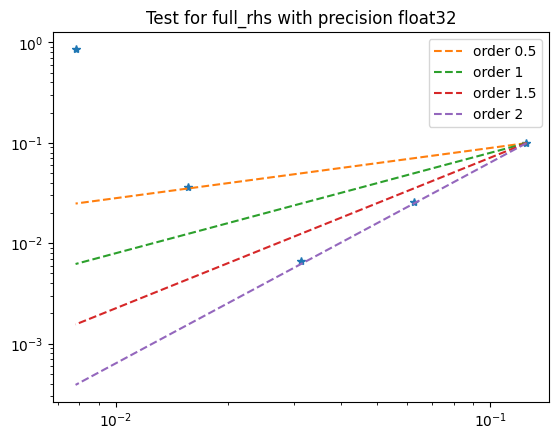

In [5]:
from voxelsss.problem_definition import PeriodicCahnHilliard
from voxelsss.utils import rhs_convergence_test

CS = spv.CoordSys3D('CS')
test_fun = 0.4 + 0.1 * sp.sin(2*sp.pi*CS.x)

precision = 'float32'
dx, errors, slope, order = rhs_convergence_test(
        ODE_class      = PeriodicCahnHilliard,
        problem_kwargs = {'eps': 3.0, 'D': 1.0, 'A': 0.25},
        test_function  = test_fun,
        convention     = 'cell_center',
        dtype          = precision,
        backend        = 'torch'
    )

print(f"Grid spacing: {dx}")
print(f"Errors:       {errors}")
print("Convergence rate from slope fit:", slope)
print("Expected order of convergence:  ", order)

plt.loglog(dx, errors,'*')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for full_rhs with precision {precision}')
plt.show()


This test shows that for fourth order spatial gradients based on a finite difference scheme, single precision is not sufficient for small dx.

## Test Allen Cahn problem

Evolution equation for two-phase evolution with controllabel curvature minimization

`curvature = 1.0` means full curvature effect is considered while for `curvature = 0.0` only the normal part of the Laplacian is considered.

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Errors:       [0.19028211 0.05396869 0.01346211 0.00334846 0.00102839]
Convergence rate from slope fit: 1.907376693930398
Expected order of convergence:   2


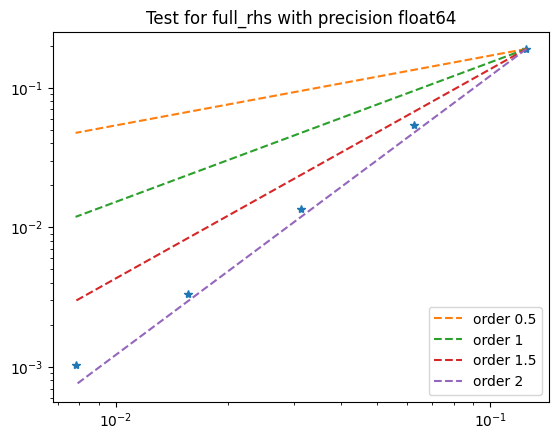

In [4]:
from voxelsss.problem_definition import AllenCahnEquation
from voxelsss.utils import rhs_convergence_test

CS = spv.CoordSys3D('CS')
test_fun = 0.5 + 0.3 * sp.cos(4*sp.pi*CS.x)\
                     * sp.cos(2*sp.pi*CS.y)\
                     * (CS.z**2/2 - CS.z**3/3)

precision = 'float64'
dx, errors, slope, order = rhs_convergence_test(
        ODE_class      = AllenCahnEquation,
        problem_kwargs = {'eps': 3.0, 'curvature': 0.5},
        test_function  = test_fun,
        convention     = 'cell_center',
        dtype          = precision
    )

print(f"Grid spacing: {dx}")
print(f"Errors:       {errors}")
print("Convergence rate from slope fit:", slope)
print("Expected order of convergence:  ", order)

plt.loglog(dx, errors,'*')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for full_rhs with precision {precision}')
plt.show()